In [2]:
import copy
import csv
import cvxpy
import datetime
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
sys.path.append('../')

from tqdm import tqdm

from skyburst import Job
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils

import logging
logger = logging.getLogger()

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [3]:
jobs = philly.load_philly_traces('~/philly-traces/trace-data')
jobs.sort(key=lambda j: j._submitted_time)
all_jobs = jobs

In [10]:
from math import floor, ceil

# Maximum job time in hours
CLIP_MAX_TIME = 1e9

# Deadline Multiplier d_t = a_t + K * r_t
DEADLINE_CONSTANT = 1.25

# Returns the deadline of a job.
# For continuous simulator
def deadline_mult_fn(arrival_time, run_time, resource_dict, deadline_mult=DEADLINE_CONSTANT):
    waiting_time = (deadline_mult - 1)*run_time
    waiting_time = max(1/12.0, waiting_time)
    return arrival_time + waiting_time + run_time


def deadline_mult_cap_fn(arrival_time, run_time, resource_dict, deadline_mult=DEADLINE_CONSTANT):
    waiting_time = (deadline_mult - 1)*run_time
    waiting_time = min(48, max(1/12.0, waiting_time))
    return arrival_time + waiting_time + run_time

def deadline_ljw(arrival_time, run_time, resource_dict, deadline_mult=DEADLINE_CONSTANT, run_thres=8.0):
    if run_time < run_thres:
        return arrival_time + run_time
    waiting_time = (deadline_mult - 1)*run_time
    return arrival_time + waiting_time + run_time

def deadline_infinite_fn(arrival_time, run_time, resource_dict):
    return 1e12

def deadline_zero_fn(arrival_time, run_time, resource_dict):
    return arrival_time + run_time

def deadline_constant_fn(arrival_time, run_time, resource_dict, wait_time=1):
    return arrival_time + wait_time + run_time

def deadline_linear_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    return arrival_time + deadline_mult * resource_dict['GPUs'] + run_time

def deadline_quad_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    return arrival_time + deadline_mult * (resource_dict['GPUs']**2) + run_time

def deadline_log_capacity_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    if resource_dict['GPUs'] ==0:
        return arrival_time + run_time
    return arrival_time + deadline_mult * (1+np.log2(resource_dict['GPUs'])) + run_time

def deadline_area_fn(arrival_time, run_time, resource_dict, deadline_mult=1):
    return arrival_time + deadline_mult * resource_dict['GPUs'] * run_time + run_time

# Returns the total cost of a job.
def gpu_cost_fn(resources: dict, run_time: float):
    return resources['GPUs'] * run_time

def time_thres_fn(job, run_thres):
    return job.runtime >= run_thres

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

# Num nodes
NUM_NODES = 16

def preprocess_jobs(jobs: List['JobTrace'], deadline_fn= deadline_infinite_fn , cost_fn=gpu_cost_fn, clip_time: float = CLIP_MAX_TIME):
    """Converts a list of jobs into (arrival_time, run_time, deadline, resources, cost).
    """
    jobs = jobs.copy()
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    
    if not clip_time:
        clip_time = 1e9
    
    # Arrival time for jobs
    start_time = jobs[0]._submitted_time
    arrival_times = [(j._submitted_time- start_time).total_seconds()/3600.0 for j in jobs]
    
    # Run time for jobs
    run_times = []
    for j in jobs:
        # Clip the maximum run time for jobs to simplify simulation.
        run_time_hr = j._run_time/60.0
        if run_time_hr > clip_time:
            run_times.append(clip_time)
        else:
            run_times.append(run_time_hr)
    
    # Get GPU resources
    resources = []
    for j in jobs:
        detail_dict = j.attempts[-1]['detail']
        gpu_count = sum([len(node_dict['gpus']) for node_dict in detail_dict])
        resources.append({'GPUs': gpu_count})
    
    deadlines = [deadline_fn(arrival, run, resource_dict) for arrival, run, resource_dict in zip(arrival_times, run_times, resources)]
    
    
    costs = [cost_fn(res, run) for res, run in zip(resources, run_times)]
    
    return [Job(idx, arr, run, dead, res, cost) \
            for idx, (arr, run, dead, res, cost) in \
            enumerate(list(zip(arrival_times, run_times, deadlines, resources, costs)))]

def generate_steady_state(jobs: List['JobTrace'], max_time=2500, arrival_param=32.0, deadline_fn= deadline_infinite_fn , cost_fn=gpu_cost_fn):
    """Converts a list of jobs into Job(arrival_time, run_time, deadline, resources, cost).
    """
    jobs = jobs.copy()
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    #num_jobs = len(jobs)
    
    # Arrival time for jobs
    np.random.seed(5)
    interarrival_times = np.random.exponential(scale=1/arrival_param, size=10000000)
    interarrival_times = np.insert(interarrival_times, 0, 0)
    sum_arrival_times = np.cumsum(interarrival_times)
    arrival_times = [a for a in sum_arrival_times if a <= max_time]
    if len(sum_arrival_times) == len(arrival_times):
        raise ValueError('lol')
    
    num_jobs = len(arrival_times)
    
    # Run time for jobs
    run_times = []
    for j in jobs:
        run_time_hr = j._run_time/60.0
        run_times.append(run_time_hr)

    # Get GPU resources
    resources = []
    for j in jobs:
        detail_dict = j.attempts[-1]['detail']
        gpu_count = sum([len(node_dict['gpus']) for node_dict in detail_dict])
        resources.append({'GPUs': gpu_count})
    np.random.seed(5)
    job_indexes = np.random.choice(list(range(len(run_times))), size=num_jobs, replace=True)
    proc_jobs = []
    for idx in range(num_jobs):
        job_idx = job_indexes[idx]
        #job_idx = idx
        resources_dict = resources[job_idx]
        runtime = run_times[job_idx]
        deadline = deadline_fn(arrival_times[idx], runtime, resources_dict)
        cost = cost_fn(resources_dict, runtime)
        proc_jobs.append(Job(idx, arrival_times[idx], runtime, deadline, resources_dict, cost))
    return proc_jobs

In [5]:
class Node(object):
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.gpu_dict = {}
        self.reserved_gpus = {}
        for idx in range(self.num_gpus):
            self.gpu_dict[idx] = None
            self.reserved_gpus[idx] = None
        self.free_gpus = num_gpus
        
    def __repr__(self):
        return f'{self.gpu_dict}'        
        
def is_subset(list1, list2):
    indexes = []
    for i2, elem in enumerate(list2):
        for i1,x in enumerate(list1):
            if x == elem and i1 not in indexes:
                indexes.append(i1)
                break
        if len(indexes) !=  i2+1:
            return []
    return indexes

        
class Cluster(object):
    
    def __init__(self, num_nodes, num_gpus_per_node, bin_pack='first-fit', backfill = False):
        self.num_nodes = num_nodes
        self.num_gpus_per_node = num_gpus_per_node
        self.nodes = [Node(num_gpus_per_node) for _ in range(num_nodes)]
        self.active_jobs = {}
        self.reserved_jobs = {}
        self.backfill = backfill
        self.bin_pack = bin_pack
    
    def is_full(self):
        return all([n.free_gpus==0 for n in self.nodes])
    
    def try_fit_v2(self, cur_timestamp, job):
        num_gpus = job.resources['GPUs']
                        
        free_gpus = [n.free_gpus for n in self.nodes]
        node_idx_to_pre_job = {}
        
        # Quick check, no hope of fitting onto cluster :(
        if num_gpus > sum(free_gpus):
            return False, []
        
        # Generate job GPU demands
        if num_gpus > self.num_gpus_per_node:
            # Assume worst case colocation
            # Multinode case, i.e. 26 GPUs, 8 GPU/node cluster -> job_gpu_demands = [8,8,8,2]
            job_gpu_demands = [self.num_gpus_per_node]*int(num_gpus/self.num_gpus_per_node)
            if num_gpus%self.num_gpus_per_node:
                job_gpu_demands.append(num_gpus%self.num_gpus_per_node)
        else:
            job_gpu_demands = [num_gpus]

        # =============================================================================
        # Generate Job Plans
        # =============================================================================
        
        # Maps node idx to list of gpu indexes for the job to take
        node_idx_taken = {}
        remove_idx = []
        
        # Go through free space only first, generate partial plan with free space
        node_free_list = [[] for _ in range(self.num_nodes)]
        node_free_count = [0]*self.num_nodes
        for n_idx, n in enumerate(self.nodes):
            # Go through reserved nodes first
            reserved_list = []
            unreserved_list = []
            for gpu_idx in range(self.num_gpus_per_node):
                if n.reserved_gpus[gpu_idx] and n.gpu_dict[gpu_idx] is None:
                    if n.reserved_gpus[gpu_idx].start >= cur_timestamp + job.runtime:
                        reserved_list.append(gpu_idx)
                elif n.gpu_dict[gpu_idx] is None and n.reserved_gpus[gpu_idx] is None:
                    unreserved_list.append(gpu_idx)
            node_free_list[n_idx] = reserved_list + unreserved_list
            node_free_count[n_idx] = len(node_free_list[n_idx])
        
        node_free_count = [(n_idx, free_gpu) for n_idx, free_gpu in enumerate(node_free_count)]
        if self.bin_pack == 'first-fit':
            pass
        elif self.bin_pack == 'best-fit':
            node_free_count.sort(key=lambda x: x[1])
        elif self.bin_pack == 'worst-fit':
            node_free_count.sort(key=lambda x: x[1], reverse=True)
        else:
            raise ValueError(f'Invalid allocation strategy {self.bin_pack}!')
        
        for list_idx, gpu_demand in enumerate(list(job_gpu_demands)):
            for n_idx, free_gpus in node_free_count:
                if n_idx in node_idx_taken:
                    continue
                
                if free_gpus >= gpu_demand:
                    # Reserved GPUs in the beginning of list
                    node_idx_taken[n_idx] = node_free_list[n_idx][:gpu_demand]
                    job_gpu_demands.remove(gpu_demand)
                    break
        
#         for list_idx, gpu_demand in enumerate(list(job_gpu_demands)):
#             for n_idx, n in enumerate(self.nodes):
#                 if n_idx in node_idx_taken:
#                     continue
#                 gpu_list = []
#                 final_gpu_count = 0             
#                 # Go through reserved GPU(s) in node
#                 free_node_list = []
#                 for gpu_idx, r_job in n.reserved_gpus.items():
#                     if r_job is None:
#                         free_node_list.append(gpu_idx)
#                     elif r_job.start >= cur_timestamp + job.runtime and n.gpu_dict[gpu_idx] is None:
#                         final_gpu_count +=1
#                         gpu_list.append(gpu_idx)
                
#                 # Then go through non-reserved GPU(s) in node
#                 for gpu_idx in free_node_list:
#                     if n.gpu_dict[gpu_idx] is None:
#                         final_gpu_count+=1
#                         gpu_list.append(gpu_idx)

#                 if final_gpu_count >= gpu_demand:
#                     node_idx_taken[n_idx] = gpu_list[:gpu_demand]
#                     job_gpu_demands.remove(gpu_demand)
#                     break
        
        # If there are still demands that cannot be satisifed via free and preempted jobs,
        # it cannot be scheduled on the cluster.
        if job_gpu_demands:
            return False, []

        # =============================================================================
        # Execute Job Plans
        # =============================================================================
        for n_idx, gpu_demand_list in node_idx_taken.items():
            node = self.nodes[n_idx]
            node.free_gpus -= len(gpu_demand_list)
            if node.free_gpus < 0:
                import pdb; pdb.set_trace()
                raise ValueError("Should not go here!")
            for idx in gpu_demand_list:
                if node.gpu_dict[idx] is not None:
                    import pdb; pdb.set_trace()
                node.gpu_dict[idx] = job
            job.allocated_gpus[n_idx] = gpu_demand_list
        job.start = cur_timestamp
        self.active_jobs[job.idx] = job
        
        return True, []
    
    def try_reserve(self, cur_timestamp, job):
        max_timestemp = job.deadline - job.runtime
        
        free_gpus = [n.free_gpus for n in self.nodes]
        active_job_list = [a_job for a_job in self.active_jobs.values()]
        active_job_list.sort(key= lambda x: x.start + x.runtime)
                
        num_gpus = job.num_gpus
        # Generate job GPU demands
        if num_gpus > self.num_gpus_per_node:
            # Multinode case, i.e. 26 GPUs, 8 GPU/node cluster -> job_gpu_demands = [8,8,8,2]
            job_gpu_demands = [self.num_gpus_per_node]*int(num_gpus/self.num_gpus_per_node)
            if num_gpus%self.num_gpus_per_node:
                job_gpu_demands.append(num_gpus%self.num_gpus_per_node)
        else:
            job_gpu_demands = [num_gpus]
        
        
        node_free_list = [[] for _ in range(self.num_nodes)]
        node_free_count = [0]*self.num_nodes
        for n_idx, node in enumerate(self.nodes):
            for gpu_idx in range(self.num_gpus_per_node):
                if node.gpu_dict[gpu_idx] or node.reserved_gpus[gpu_idx]:
                    continue
                node_free_count[n_idx] +=1
                node_free_list[n_idx].append(gpu_idx)
        
        for a_job in active_job_list:
            if a_job.start + a_job.runtime > job.deadline - job.runtime:
                return False
            
            for n_idx, gpu_list in a_job.allocated_gpus.items():
                for gpu_idx in gpu_list:
                    if self.nodes[n_idx].reserved_gpus[gpu_idx]:
                        continue
                    node_free_list[n_idx].append(gpu_idx)
                    node_free_count[n_idx]+=1
            
            node_indexes = is_subset(node_free_count, job_gpu_demands)
            if node_indexes:
                for idx, n_idx in enumerate(node_indexes):
                    gpu_list = node_free_list[n_idx][-job_gpu_demands[idx]:]
                    job.allocated_gpus[n_idx] = gpu_list
                    cur_node = self.nodes[n_idx]
                    for gpu_idx in gpu_list:
                        cur_node.reserved_gpus[gpu_idx] = job
                self.reserved_jobs[job.idx] = job
                job.block_job_idx = a_job.idx
                job.start = a_job.start + a_job.runtime
                return True
        raise ValueError('I should not go here!')
            
    def try_clear(self, t: float):
        """Clears cluster of completed jobs.
        """
        completed_jobs = []
        for job_idx, job in self.active_jobs.items():
            if t >= job.start + job.runtime:
                for node_idx, gpu_list in job.allocated_gpus.items():
                    cur_node = self.nodes[node_idx]
                    node_gpu_dict = cur_node.gpu_dict
                    for gpu_idx in gpu_list:
                        node_gpu_dict[gpu_idx] = None
                    cur_node.free_gpus += len(gpu_list)
                completed_jobs.append(job)
        
        c_job_idx = []
        for job in completed_jobs:
            job.state = 'LOCAL'
            c_job_idx.append(job.idx)
            del self.active_jobs[job.idx]
        
        # Go through reserved jobs
        r_job_delete_idx = []
        for r_job_idx, r_job in self.reserved_jobs.items():
            # Move reserved job to active jobs
            if r_job.block_job_idx in c_job_idx:
                if t > r_job.start:
                    raise ValueError('sus')
                for node_idx, gpu_list in r_job.allocated_gpus.items():
                    cur_node = self.nodes[node_idx]
                    for gpu_idx in gpu_list:
                        cur_node.gpu_dict[gpu_idx] = r_job
                        cur_node.reserved_gpus[gpu_idx] = None
                    cur_node.free_gpus -= len(gpu_list)
                    if cur_node.free_gpus < 0:
                        import pdb; pdb.set_trace()
                r_job_delete_idx.append(r_job_idx)
                self.active_jobs[r_job_idx] = r_job
        
        for r_job_idx in r_job_delete_idx:
            del self.reserved_jobs[r_job_idx]
                             
        return completed_jobs
    
    def __repr__(self):
        repr_str = 'Cluster State:\n'
        for idx, n in enumerate(self.nodes):
            repr_str += f'Node {idx}: {n}\n'
        return repr_str

In [191]:
## Attempt Pre-emption
# Add job into the cluster -> pre empt jobs (what jobs to preempt?)
# Only preempt jobs that have reached deadline & are cheaper than the current job
# Preempted jobs go back into the queue
def continuous_simulator(jobs: List[Job], policy, num_nodes, job_filter_policy=None, snapshot=False, verbose=False, debug=False):
    original_policy_str = copy.deepcopy(policy)
    if '-' in policy:
        policy_list = policy.split('-')
        policy = policy_list[0]
        mods = policy_list[1:]
    else:
        mods = []
    
    if policy == 'fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'lifo':
        sort_func = lambda x: -x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'evdf':
        sort_func = lambda x: x.deadline * x.num_gpus
    elif policy == 'ldf':
        sort_func = lambda x: -x.deadline
    elif policy == 'sjf':
        sort_func = lambda x: x.runtime
    elif policy == 'svjf':
        sort_func = lambda x: x.cost
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    elif policy == 'swf':
        sort_func = lambda x: x.deadline - x.runtime 
    elif policy == 'svwf':
        sort_func = lambda x: (x.deadline - x.runtime)*x.num_gpus
    elif policy == 'lwf':
        sort_func = lambda x: -x.deadline + x.runtime
    else:
        pass
        #raise ValueError(f'Policy {policy} does not match!')
    
    bin_pack_policy = 'first-fit'
    remove_hol = False
    backfill = False
    for mod in mods:
        if mod == 'nohol':
            remove_hol=True
        if mod == 'backfill':
            backfill=True
        if mod == 'first':
            bin_pack_policy = 'first-fit'
        if mod == 'best':
            bin_pack_policy = 'best-fit'
        if mod == 'worst':
            bin_pack_policy = 'worst-fit'
    
    job_filter_fn = None
    if job_filter_policy is not None:
        job_filter_policy, run_thres = job_filter_policy.split('-')
        if job_filter_policy == 'ljw':
            job_filter_fn = lambda x: time_thres_fn(x, float(run_thres))
        else:
            raise ValueError(f'Incorrect job filter policy {job_filter_policy}.')
    
    finished_jobs = []
    jobs = copy.deepcopy(jobs)
    num_jobs = len(jobs)
    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=num_nodes, num_gpus_per_node=GPUS_PER_NODE, backfill=backfill, bin_pack=bin_pack_policy)
    t=0
    snapshots = {}
    #tqdm_iter = tqdm(total=len(jobs), desc ="# of Jobs left")
    while len(jobs) >0 or len(queue)>0 or cluster.active_jobs:
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        # Check for jobs that have waited too long (move to cloud).
        i=0
        while i < len(queue):
            job = queue[i]
            if t >= job.deadline - job.runtime:
                queue.remove(job)
                job.state = 'TIMEOUT-CLOUD'
                job.start = job.deadline - job.runtime
                finished_jobs.append(job)
            else:
                i+=1
        
        # Add jobs to queue that have arrived
        i=0
        while i < len(jobs):
            job = jobs[i]
            if job.arrival < t:
                raise ValueError("Should not have entered here!")
                
            if job.arrival == t:
                jobs.remove(job)
                #tqdm_iter.update(1)
#                 if job.idx%1000==0:
#                     logging.info(f'{policy}-{num_nodes}: {job.idx}')
                if job_filter_fn is not None:
                    # If arrival job does not satisfy job filter, move job to cloud.
                    if not job_filter_fn(job):
                        job.state = 'FILTER-CLOUD'
                        finished_jobs.append(job)
                        continue
                queue.append(job)
            else:
                break
        
        if policy == 'llf':
            sort_func = lambda x: x.deadline - t - x.runtime
        elif policy == 'llfv':
            sort_func = lambda x: (x.deadline - t - x.runtime)*x.num_gpus
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        preempted_jobs = []
        i =0
        while i < len(queue):
            job = queue[i]
            can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
            if can_fit:
                queue.remove(job)
                queue.extend(preempted_jobs)
            elif not remove_hol:
                break
            else:
                i+=1
        
        # Perform EASY backfilling
        if backfill:
            # Reserve the first element of queue that is blocking
            if queue:
                job_to_reserve = queue[0]
                can_reserve = cluster.try_reserve(t, job_to_reserve)
                # If can't reserve within reasonble time (before deadline), move the job to the cloud
                if not can_reserve:
#                     job_to_reserve.block_job_idx = 'hi'
                    pass
#                     queue.remove(job_to_reserve)
#                     job_to_reserve.state = 'FILTER-CLOUD'
#                     job_to_reserve.start = t
#                     finished_jobs.append(job_to_reserve)
                else:
                    queue.remove(job_to_reserve)
                i=0
                while i < len(queue):
                    job = queue[i]
                    can_fit, preempted_jobs = cluster.try_fit_v2(t, job)
                    if can_fit:
                        queue.remove(job)
                        queue.extend(preempted_jobs)
                    else:
                        i+=1
                    
        next_time_list = []
        if snapshot:
            if t not in snapshots:
                snapshots[t] = {}
            snapshots[t]['new_queue'] = copy.deepcopy(queue)
        
        # Skip to next timestep where a new job either arrives or when a job finishes on the cluster.
        for job_idx, job in cluster.active_jobs.items():
            release_time = job.start + job.runtime
            next_time_list.append(release_time)

        if len(jobs)>0:
            next_time_list.append(jobs[0].arrival)
        
        if len(next_time_list)==0:
            assert len(queue)==0 and len(jobs) ==0
            break
        
        if min(next_time_list) < t:
            raise ValueError('Simulator is severely bugged; Raise a Git Issue.')
                
        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        
        t = min(next_time_list)
    finished_jobs.extend(cluster.try_clear(1e12))
    assert len(jobs)==0 and len(queue)==0

    
    policy = original_policy_str
    print(f'{policy}-{num_nodes}')
    print(len(finished_jobs))
    if snapshot:
        return f'{policy}-{num_nodes}', save_simulator_results(finished_jobs), snapshots
    else:
        return f'{policy}-{num_nodes}', save_simulator_results(finished_jobs)

def save_simulator_results(finished_jobs: List[Job]) -> dict:
    result_dict = {
        'idx': [],
        'arrival': [],
        'start': [],
        'runtime': [],
        'deadline': [],
        'num_gpus': [],
        'state': [],
        'allocated_gpus': [],
    }
    finished_jobs.sort(key = lambda x: x.idx)
    for job in finished_jobs:
        result_dict['idx'].append(job.idx)
        result_dict['arrival'].append(job.arrival)
        if job.start is not None:
            result_dict['start'].append(job.start)
        else:
            result_dict['start'].append(-1)
        result_dict['runtime'].append(job.runtime)
        result_dict['deadline'].append(job.deadline)
        result_dict['num_gpus'].append(job.num_gpus)
        result_dict['state'].append(job.state)
        result_dict['allocated_gpus'].append(job.allocated_gpus)
    result_dict['idx'] = np.array(result_dict['idx'])
    result_dict['arrival'] = np.array(result_dict['arrival'])
    result_dict['start'] = np.array(result_dict['start'])
    result_dict['runtime'] = np.array(result_dict['runtime'])
    result_dict['deadline'] = np.array(result_dict['deadline'])
    result_dict['num_gpus'] = np.array(result_dict['num_gpus'])
    result_dict['state'] = np.array(result_dict['state'])
    result_dict['allocated_gpus'] = np.array(result_dict['allocated_gpus'])
    
    # Compute utilization at Steady State
    total_waiting_time = 0.0
    num_jobs = 0
    sum_space = 0 
    cloud_cost=  0
    for job in finished_jobs:
        # remove warmup and cooldown period
        if job.idx < 2000 or job.idx > len(finished_jobs)-2000:
            if job.state == 'LOCAL':
                inter_end =  min(job.start + job.runtime, 2000)
                inter_start = max(job.start, 1000)
                if inter_end >= inter_start:
                    sum_space += job.num_gpus * (inter_end - inter_start)
            continue
        # Moved to cloud
        if job.state == 'TIMEOUT-CLOUD':
#             total_waiting_time += 0
            total_waiting_time += job.start - job.arrival
            cloud_cost += job.cost
        elif job.state == 'FILTER-CLOUD':
            assert job.start is not None
            total_waiting_time += 0
            cloud_cost += job.cost
        elif job.state == 'LOCAL':
            assert job.state == 'LOCAL'
            inter_end =  min(job.start + job.runtime, 2000)
            inter_start = max(job.start, 1000)
            if inter_end >= inter_start:
                sum_space += job.num_gpus * (inter_end - inter_start)
            total_waiting_time += job.start - job.arrival
        num_jobs+=1
        
    result_dict['jct'] = np.mean(result_dict['runtime']) + (total_waiting_time/num_jobs)
    avg_jct = result_dict['jct']
    # At steady state
    result_dict['cluster_utilization'] =  sum_space/(512*1000)
    steady_state_cluster_utilization = result_dict['cluster_utilization']
    print(f'Avg JCT: {avg_jct}')
    print(f'Avg Cluster Utilization: {steady_state_cluster_utilization}')
    print(f'Cloud Cost: {cloud_cost}')
    print(f'Avg Waiting Time: {total_waiting_time/num_jobs}')
    return result_dict

In [192]:
# All equilvanet in terms of waiting budget
infinite_fn = lambda x,y,z: deadline_infinite_fn(x,y,z)
temp_fn = lambda x, y, z: deadline_mult_fn(x,y,z,deadline_mult=1.25)
const_fn = lambda x, y, z: deadline_constant_fn(x,y,z,wait_time=1.045615182205313)
linear_capacity_fn = lambda x,y,z: deadline_linear_capacity_fn(x,y,z, deadline_mult=0.7912912710329504)
log_capacity_fn = lambda x,y,z: deadline_log_capacity_fn(x,y,z, deadline_mult=0.9102791702708073)
quad_capacity_fn = lambda x,y,z: deadline_log_capacity_fn(x,y,z, deadline_mult=0.19027535563997805)


algs = ['fifo']
#num_nodes = [72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136] #[105, 110, 120, 125]
arrival_params = list(range(4, 85, 4))
infinite_arrival_params = [4,8,12,16,20,24,26,27,28,29,30,31,32]

print(algs)
def steady_state_search(jobs, algs, arrival_params, num_nodes, deadline_fn):
    tuples = []
    zip_tuples = []
    for arrival_param in arrival_params:
        jobs_proc = generate_steady_state(jobs, 2500, \
                arrival_param=arrival_param, deadline_fn=deadline_fn)
        for alg in algs:
            tuples.append((jobs_proc, alg, num_nodes))
            zip_tuples.append(f'{alg}-{arrival_param}')
    results = []
    with multiprocessing.Pool(processes=48) as pool:
        results = pool.starmap(continuous_simulator, tuples)
    results_dict = {}
    assert len(results) == len(zip_tuples)
    for k1, k2 in zip(zip_tuples, results):
            results_dict[k1] = k2[1]
    return results_dict

# algs = ['fifo-backfill']
# hybrid_results = steady_state_search(all_jobs, algs, arrival_params, 64, temp_fn)
# file = open(f'logs/background/starburst.log', 'wb')
# pickle.dump(hybrid_results, file)
# file.close()

# algs = ['fifo']
# hybrid_results = steady_state_search(all_jobs, algs, arrival_params, 64, deadline_zero_fn)
# file = open(f'logs/background/nowait.log', 'wb')
# pickle.dump(hybrid_results, file)
# file.close()


# algs = ['fifo']
# hybrid_results = steady_state_search(all_jobs, algs, infinite_arrival_params, 64, deadline_infinite_fn)
# file = open(f'logs/background/infinite.log', 'wb')
# pickle.dump(hybrid_results, file)
# file.close()


algs = ['fifo']
hybrid_results = steady_state_search(all_jobs, algs, arrival_params, 64, const_fn)
file = open(f'logs/background/constant.log', 'wb')
pickle.dump(hybrid_results, file)
file.close()


['fifo']
fifo-64
9964
Avg JCT: 4.079124291895267
Avg Cluster Utilization: 0.0894448653221153
Cloud Cost: 0
Avg Waiting Time: 0.0
fifo-64
19735
Avg JCT: 4.113280677307659
Avg Cluster Utilization: 0.2196743272138214
Cloud Cost: 0
Avg Waiting Time: 0.0
fifo-64
29694
Avg JCT: 4.0437981204583044
Avg Cluster Utilization: 0.34074480667406354
Cloud Cost: 0
Avg Waiting Time: 0.0
fifo-64
39778
Avg JCT: 4.107858175373322
Avg Cluster Utilization: 0.42623237855308005
Cloud Cost: 0
Avg Waiting Time: 0.0
fifo-64
49931
Avg JCT: 4.1624881503141005
Avg Cluster Utilization: 0.5460138918234221
Cloud Cost: 0
Avg Waiting Time: 0.0
fifo-64
59882
Avg JCT: 4.130228128953013
Avg Cluster Utilization: 0.6643233963456453
Cloud Cost: 0
Avg Waiting Time: 4.4341578585115394e-05
fifo-64
69739
Avg JCT: 4.093617623233827
Avg Cluster Utilization: 0.7737189958459861
Cloud Cost: 4737.070555555555
Avg Waiting Time: 0.0035671612732794795
fifo-64
79697
Avg JCT: 4.066422723947639
Avg Cluster Utilization: 0.8634272498462537
Clo

In [35]:
def create_results_df(simulator_results: dict):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'input_rate': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float'),
                    'utilization': pd.Series(dtype='float'),
                    'jct': pd.Series(dtype='float')})
    algs = []
    num_nodes_list = []
    cloud_costs = []
    waiting_times = []
    for key, finished_jobs in simulator_results.items():
        token_list = key.split('-')
        if len(token_list)>0:
            alg =  '-'.join(token_list[:-1])
            input_rate = token_list[-1]
        else:
            alg = f'{token_list[0]}-{token_list[1]}'
            input_rate = token_list[2]
        input_rate = int(input_rate)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        count = 0
        for idx in range(len(finished_jobs['idx'])):
            if idx < 2000 or idx > len(finished_jobs['idx']) - 2000:
                continue
            arrival = finished_jobs['arrival'][idx]
            start = finished_jobs['start'][idx]
            if finished_jobs['state'][idx] != 'LOCAL':
                runtime = finished_jobs['runtime'][idx]
                cloud_cost += finished_jobs['num_gpus'][idx] * runtime
                if finished_jobs['state'][idx] == 'FILTER-CLOUD':
                    total_waiting_time += start - arrival
                else:
                    deadline = finished_jobs['deadline'][idx]
                    total_waiting_time += deadline - runtime - arrival
            else:
                total_waiting_time += start - arrival
            count+=1
        avg_waiting_time = total_waiting_time / count
        df = pd.DataFrame(data={'alg': [alg], 'input_rate': [input_rate], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time], \
                               'utilization': finished_jobs['cluster_utilization'], 'jct': finished_jobs['jct']})
        results_df = pd.concat([results_df, df], ignore_index=True)
    return results_df

In [161]:
results={}
hybrid_results_df = pd.DataFrame()
for agent in ['nowait', 'infinite', 'constant', 'starburst']:
    num_nodes = 64
    file = open(f'logs/background/{agent}.log', 'rb')
    results[agent] = pickle.load(file)
    temp_df = create_results_df(results[agent])
    print(temp_df)
    temp_df['agent'] = agent
    hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)
    

     alg  input_rate          cost  waiting_time  utilization       jct
0   fifo           4  0.000000e+00  0.000000e+00     0.089445  4.079124
1   fifo           8  0.000000e+00  0.000000e+00     0.219674  4.113281
2   fifo          12  0.000000e+00  0.000000e+00     0.340745  4.043798
3   fifo          16  0.000000e+00  0.000000e+00     0.426232  4.107858
4   fifo          20  0.000000e+00  0.000000e+00     0.546014  4.162488
5   fifo          24  1.536711e+02  0.000000e+00     0.664023  4.130184
6   fifo          28  1.756847e+03  0.000000e+00     0.778429  4.090050
7   fifo          32  3.077989e+04 -3.003695e-18     0.860252  4.043293
8   fifo          36  9.661809e+04  1.989085e-18     0.890514  4.014561
9   fifo          40  1.864705e+05  5.938386e-19     0.908189  4.031552
10  fifo          44  3.039156e+05  2.423636e-18     0.911338  4.002770
11  fifo          48  4.119504e+05 -1.132781e-17     0.927207  3.963366
12  fifo          52  5.346090e+05 -2.039933e-18     0.931000  3

In [162]:
avg_job_volume_rate = np.mean(results['infinite']['fifo-24']['num_gpus']* results['infinite']['fifo-24']['runtime'])
print(avg_job_volume_rate)

14.233220996663809


In [299]:
def plot_cost_and_waiting_graph(results_df, normalized=False):
#     options = ['fifo', 'lifo', 'lifo-nohol']
#     results_df = results_df[results_df['alg'].isin(options)]
    plt.rcParams.update({'font.size': 15})
    results_df = results_df[results_df['agent']!='constant']
    # Get current default figsize
    default_figsize = plt.rcParams.get('figure.figsize')
    # Set the new figsize as the default
    fig, (ax, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.5))
    ax.grid(True)
    ax2.grid(True, which='both')
    ax3.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    #ax.spines['bottom'].set_color('#DDDDDD')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(True)
    ax2.spines['bottom'].set_visible(True)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(True)
    ax3.spines['bottom'].set_visible(True)

    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.yaxis.grid(False, color='#EEEEEE')
    #ax.xaxis.grid(False)
    
    
    ax2.tick_params(bottom=False, left=False)
    ax2.set_axisbelow(True)
    #ax2.xaxis.grid(False)
    
    ax3.tick_params(bottom=False, left=False)
    ax3.set_axisbelow(True)
#     ax3.xaxis.grid(False)

    # Input volume/output volume
    # Input volume = input rate over 1 hr * avg job volume
    # output volume = num_gpus in cluster * 1 hr
    x_axis = 'normalized_input_rate'
    results_df['normalized_input_rate'] = results_df['input_rate'] * avg_job_volume_rate / (64 * 8)
    label_x = 'Avg. System Utilization (r/c)'
    
    baseline_df =  results_df[results_df['agent']=='nowait']
    diff_df = pd.merge(baseline_df,
               results_df, left_on=['input_rate', 'normalized_input_rate'],right_on=['input_rate', 'normalized_input_rate'])
    
    
    def cost_multiplier(row):
        baseline_cost = row['cost_x']
        cost = row['cost_y']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost==0:
            return 100 
        return 100* (1 - (cost/baseline_cost))
    
    diff_df['cost_diff'] = diff_df.apply(cost_multiplier, axis=1)

    for idx, (label, grp) in enumerate(diff_df.groupby('agent_y')):
        if label=='starburst':
            marker = "s"
            color = 'tab:red'
        elif label == 'infinite':
            marker = 'v'
            color = 'tab:blue'
        elif label == 'nowait':
            marker = '^'
            color = 'tab:orange'
        elif label == 'constant':
            marker = 'o'
            color = 'tab:green'
        style = None
        a1 = grp.plot(x = x_axis, y = 'jct_y',ax = ax, marker=marker, label = label, legend=None, xlabel=label_x, \
                ylabel='Avg. JCT (hrs)', color=color)
        a2 = grp.plot(x = x_axis, y = 'utilization_y', ax = ax2, marker=marker, label = label, legend=None, xlabel=label_x, \
                      ylabel = 'Cluster Utilization', logy=False, style=style, color=color)
        a3 = grp.plot(x = x_axis, y = 'cost_diff', ax = ax3, marker=marker, label = label, legend=None, xlabel=label_x, \
              ylabel ='% Cost Savings w.r. No-Wait', logy=False, style=style, color=color)
    
    lines, labels = ax.get_legend_handles_labels()
#     print(lines)
#     print(labels)
    fig.legend(lines, ['∞-Wait', 'No-Wait', 'Starburst'], ncol=len(labels), \
               bbox_to_anchor=(0, 0.88, 1, 0.2),loc='upper center')
    
#     fig.legend([lines[1], lines[2], lines[0], lines[3]], ['∞-Wait', 'No-Wait', '1-Wait', 'Starburst'], ncol=len(labels), \
#               bbox_to_anchor=(0, 0.88, 1, 0.2), loc="upper center")
    ax.grid(True, which='both')
    ax2.grid(True, which='both')
    ax3.grid(True, which='both')
    ax.set_ylim(top=7, bottom=3.8)
    ax.set_xlim(left=0.2, right=2.03)
    ax2.set_xlim(left=0.7, right=2.03)
    ax2.set_ylim(bottom=0.68)
    ax3.set_xlim(left=0.2, right=2.03)
    ax3.set_ylabel('% Cost Savings\nover No-Wait', fontsize=14, multialignment='center')
    ax.axvline(x=0.90, color='tab:blue', linestyle='--')
    ax2.axvline(x=0.90, color='tab:blue', linestyle='--')
    ax3.axvline(x=0.90, color='tab:blue', linestyle='--')
    
    plt.tight_layout()
    plt.savefig('figures/background/why_starburst.pdf', bbox_inches="tight")
    plt.show()  

/tmp/ipykernel_3237/51738175.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['normalized_input_rate'] = results_df['input_rate'] * avg_job_volume_rate / (64 * 8)


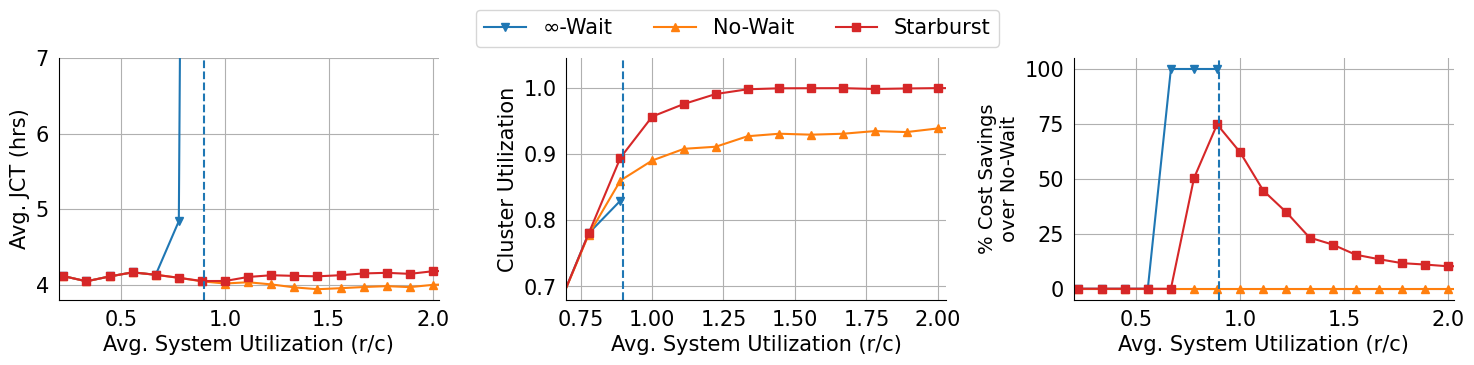

In [300]:
plot_cost_and_waiting_graph(hybrid_results_df)